# Predicting oil palm plantation from satellite image

In [ ]:
from google.colab import drive
from shutil import copytree

drive.mount('/content/drive')

source_folder_path = '/content/drive/MyDrive/CourseProject'

destination_folder_path = '/content/training_data'

copytree(source_folder_path, destination_folder_path)

Mounted at /content/drive


'/content/training_data'

In [ ]:
import zipfile

zip_file_path = '/content/training_data/train_images-2.zip'

destination_folder_path = '/content/train_images'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(destination_folder_path)

In [ ]:
import pandas as pd
import numpy as np
import os
import shutil
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import tensorflow as tf
from keras.applications import VGG19
from keras.preprocessing import image
from keras.layers import GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dense, Input
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.optimizers import Adam, SGD

In [ ]:
labels = pd.read_csv('training_data/traininglabels.csv')
labels['image_id'] = labels['image_id'].str.replace('2017.jpg', '.jpg', regex=False)
labels['image_id'] = labels['image_id'].str.replace('2018.jpg', '.jpg', regex=False)
images = os.listdir('train_images/train_images/')
print(len(images))

11001


In [ ]:
import shutil
import pandas as pd
import os

labels_filtered = labels[labels['image_id'].isin(images)]
labels_filtered.to_csv('labels.csv')
labels = pd.read_csv('labels.csv')


folder_path = 'train_set'
os.mkdir(folder_path)

subfolder1_path = os.path.join(folder_path, '0')
os.mkdir(subfolder1_path)

subfolder2_path = os.path.join(folder_path, '1')
os.mkdir(subfolder2_path)

for img in images:
        source = 'train_images/train_images/'+img
        result = labels[labels['image_id'] == img]
        if not result.empty:
          label = result.iloc[0]['has_oilpalm']
          if label == 0:
            shutil.copy(source,'train_set/0/'+ img)
          else:
            shutil.copy(source,'train_set/1/'+ img)

In [ ]:
folder_path = 'test_set'
os.mkdir(folder_path)

subfolder1_path = os.path.join(folder_path, '0')
os.mkdir(subfolder1_path)

subfolder2_path = os.path.join(folder_path, '1')
os.mkdir(subfolder2_path)

positive_img = os.listdir('train_set/1/') 

r1 = random.sample(range(len(positive_img)), 150)

for i in r1:
        source = 'train_set/1/'+positive_img[i]
        shutil.copy(source,'test_set/1/'+positive_img[i] )
       

In [ ]:
negative_img = os.listdir('train_set/0/')

r0 = random.sample(range(len(negative_img)), 1500) 

for i in r0:
        source = 'train_set/0/'+negative_img[i]
        shutil.copy(source,'test_set/0/'+negative_img[i] )

test_set/1/img_04840.jpg


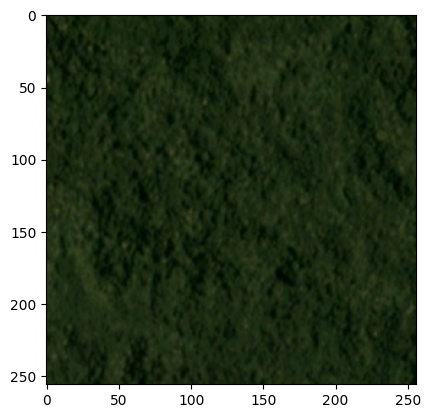

In [ ]:
plt.imshow(mpimg.imread('test_set/1/'+os.listdir('test_set/1/') [1]))
print('test_set/1/'+os.listdir('test_set/1/') [1])

test_set/1/img_06860.jpg


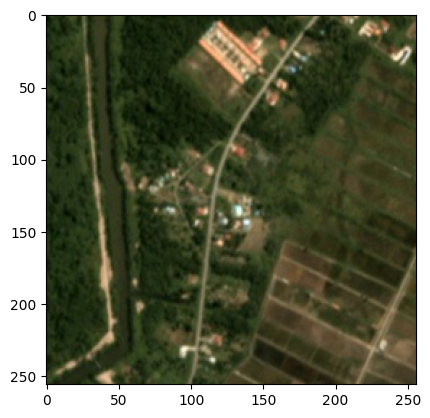

In [ ]:
plt.imshow(mpimg.imread('test_set/1/'+os.listdir('test_set/1/') [10]))
print('test_set/1/'+os.listdir('test_set/1/') [10])

In [ ]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = 'train_set'
valid_dir = 'test_set'

image_size = (128, 128)
num_classes = 2

training_images_num = len(os.listdir('train_set/0/')) + len(os.listdir('train_set/1/'))
test_images_num = len(os.listdir('test_set/0/')) + len(os.listdir('test_set/1/'))

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=32,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=image_size,
    batch_size=32,
    class_mode='categorical'
)

base_model = VGG19(weights='imagenet', include_top=False, input_shape=(128, 128, 3))


for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Dense(num_classes, activation='sigmoid'))

filepath = 'model/VGG19.h5'
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1,save_best_only=True, mode='max')
callbacks_list = [checkpoint]

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_generator, validation_data=valid_generator, validation_steps=test_images_num // 32, callbacks=callbacks_list, steps_per_epoch=training_images_num // 32, batch_size=32, epochs=10)

Found 9877 images belonging to 2 classes.
Found 1650 images belonging to 2 classes.
Epoch 1/10
308/308 [==============================] - ETA: 0s - loss: 0.4117 - accuracy: 0.8428
Epoch 1: accuracy improved from -inf to 0.84276, saving model to model/VGG19.h5
308/308 [==============================] - 71s 222ms/step - loss: 0.4117 - accuracy: 0.8428 - val_loss: 0.3184 - val_accuracy: 0.9216
Epoch 2/10
308/308 [==============================] - ETA: 0s - loss: 0.2202 - accuracy: 0.9324
Epoch 2: accuracy improved from 0.84276 to 0.93235, saving model to model/VGG19.h5
308/308 [==============================] - 66s 215ms/step - loss: 0.2202 - accuracy: 0.9324 - val_loss: 0.2251 - val_accuracy: 0.9332
Epoch 3/10
308/308 [==============================] - ETA: 0s - loss: 0.1979 - accuracy: 0.9360
Epoch 3: accuracy improved from 0.93235 to 0.93601, saving model to model/VGG19.h5
308/308 [==============================] - 64s 208ms/step - loss: 0.1979 - accuracy: 0.9360 - val_loss: 0.1880 - v

In [ ]:
base_model_finetune = VGG19(include_top=False, weights=None,input_shape=(128,128,3))

for layer in base_model_finetune.layers:
    layer.trainable = True

model_finetune = Sequential()
model_finetune.add(base_model_finetune)
model_finetune.add(GlobalAveragePooling2D())
model_finetune.add(Dense(128, activation='relu'))
model_finetune.add(Dropout(0.4))
model_finetune.add(Dense(128, activation='relu'))
model_finetune.add(Dropout(0.4))
model_finetune.add(BatchNormalization())
model_finetune.add(Dense(num_classes, activation='sigmoid'))

In [ ]:
filepath = 'model/fine_tune_VGG19.h5'
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1,save_best_only=True,save_weights_only=False, mode='auto',save_freq='epoch')
callbacks_list = [checkpoint]

model_finetune.load_weights('model/VGG19.h5')
model_finetune.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=0.0001, momentum=0.9), metrics=['accuracy'])
model.fit(train_generator, validation_data=valid_generator, validation_steps=test_images_num // 32, callbacks=callbacks_list, steps_per_epoch=training_images_num // 32, batch_size=32, epochs=10)

Epoch 1/10
308/308 [==============================] - ETA: 0s - loss: 0.1573 - accuracy: 0.9429
Epoch 1: accuracy improved from -inf to 0.94292, saving model to model/fine_tune_VGG19.h5
308/308 [==============================] - 66s 213ms/step - loss: 0.1573 - accuracy: 0.9429 - val_loss: 0.2028 - val_accuracy: 0.9387
Epoch 2/10
308/308 [==============================] - ETA: 0s - loss: 0.1572 - accuracy: 0.9434
Epoch 2: accuracy improved from 0.94292 to 0.94342, saving model to model/fine_tune_VGG19.h5
308/308 [==============================] - 63s 204ms/step - loss: 0.1572 - accuracy: 0.9434 - val_loss: 0.1764 - val_accuracy: 0.9344
Epoch 3/10
308/308 [==============================] - ETA: 0s - loss: 0.1526 - accuracy: 0.9447
Epoch 3: accuracy improved from 0.94342 to 0.94474, saving model to model/fine_tune_VGG19.h5
308/308 [==============================] - 64s 208ms/step - loss: 0.1526 - accuracy: 0.9447 - val_loss: 0.1806 - val_accuracy: 0.9375
Epoch 4/10
308/308 [==============

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = 'train_set'
valid_dir = 'test_set'

image_size = (128, 128)
num_classes = 2

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=32,
    class_mode='binary'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=image_size,
    batch_size=32,
    class_mode='binary'
)

base_model = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(image_size[0], image_size[1], 3)
)

for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

filepath = 'model/ResNet50.h5'
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1,save_best_only=True, mode='max')

model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    callbacks=[checkpoint],
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size
)

for layer in base_model.layers:
    layer.trainable = True

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

filepath = 'model/ResNet50_fine_tuned.h5'
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1,save_best_only=True, mode='max')

model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    callbacks=[checkpoint],
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size
)


Found 9877 images belonging to 2 classes.
Found 1650 images belonging to 2 classes.
Epoch 1/10
308/308 [==============================] - ETA: 0s - loss: 0.2395 - accuracy: 0.9373
Epoch 1: accuracy improved from -inf to 0.93733, saving model to model/ResNet50.h5
308/308 [==============================] - 70s 213ms/step - loss: 0.2395 - accuracy: 0.9373 - val_loss: 0.3040 - val_accuracy: 0.9087
Epoch 2/10
308/308 [==============================] - ETA: 0s - loss: 0.2337 - accuracy: 0.9368
Epoch 2: accuracy did not improve from 0.93733
308/308 [==============================] - 62s 203ms/step - loss: 0.2337 - accuracy: 0.9368 - val_loss: 0.3063 - val_accuracy: 0.9081
Epoch 3/10
308/308 [==============================] - ETA: 0s - loss: 0.2310 - accuracy: 0.9371
Epoch 3: accuracy did not improve from 0.93733
308/308 [==============================] - 64s 206ms/step - loss: 0.2310 - accuracy: 0.9371 - val_loss: 0.2970 - val_accuracy: 0.9099
Epoch 4/10
308/308 [=============================

In [ ]:
import os
import tensorflow as tf
from tensorflow import keras

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("model.tflite", "wb").write(tflite_model)

95029740

In [ ]:
from google.colab import drive
from shutil import copytree
import shutil

drive.mount('/content/drive')

source_folder_path = '/content/drive/MyDrive/CourseProject/'

destination_folder_path = '/content/training_data'

copytree(source_folder_path, destination_folder_path)

Mounted at /content/drive


'/content/training_data'

In [ ]:
import zipfile

zip_file_path = '/content/training_data/training_set.zip'

destination_folder_path = '/content/training_set'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(destination_folder_path)

In [ ]:
import pandas as pd
import os

labels = pd.read_csv('training_data/traininglabels.csv')
images = os.listdir('training_set/training_set')

In [ ]:
import shutil
import pandas as pd
import os

labels = pd.read_csv('training_data/traininglabels.csv')
images = os.listdir('training_set/training_set')

labels_filtered = labels[labels['image_id'].isin(images)]
labels_filtered.to_csv('labels.csv')
labels = pd.read_csv('labels.csv')


folder_path = 'training_images'
os.mkdir(folder_path)

subfolder1_path = os.path.join(folder_path, '0')
os.mkdir(subfolder1_path)

subfolder2_path = os.path.join(folder_path, '1')
os.mkdir(subfolder2_path)

for img in images:
        source = 'training_set/training_set/'+img
        result = labels[labels['image_id'] == img]
        if not result.empty:
          label = result.iloc[0]['has_oilpalm']
          if label == 0:
            shutil.copy(source,'training_images/0/'+ img)
          else:
            shutil.copy(source,'training_images/1/'+ img)

In [ ]:
from fastai.vision import *
from fastai.metrics import accuracy
from fastai.vision.all import *

path = 'training_images/'
size = 256
batch_size = 256

In [ ]:
block = DataBlock(blocks=(ImageBlock, CategoryBlock),
                get_items = get_image_files,
                splitter = RandomSplitter(valid_pct=0.2, seed=42),
                get_y = parent_label,
                item_tfms = RandomResizedCrop(200, min_scale=0.5),
                batch_tfms = aug_transforms(do_flip=True, flip_vert=True)
               )

data = block.dataloaders(Path('training_images'), bs = 32)

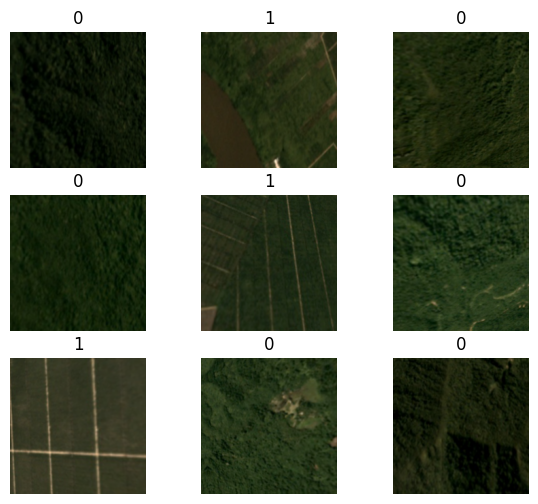

In [ ]:
data.show_batch(figsize=(7,6))

In [ ]:
resnet18_model = vision_learner(data, resnet18, metrics=accuracy)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
resnet18_model.fit_one_cycle(5)


epoch,train_loss,valid_loss,accuracy,time
0,0.419106,0.054268,0.981758,05:27
1,0.173271,0.032980,0.990050,05:21
2,0.104916,0.028152,0.986733,05:18
3,0.108838,0.013674,0.993366,05:16
4,0.075962,0.011336,0.995025,05:12


In [ ]:
resnet18_model.export('fastai_model_resnet18.pkl')

In [ ]:
resnet50_model = vision_learner(data, resnet50, metrics=accuracy)

resnet50_model.fit_one_cycle(5)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 144MB/s]


epoch,train_loss,valid_loss,accuracy,time
0,0.281724,0.079881,0.971808,13:26
1,0.165012,0.023392,0.988391,13:25
2,0.110511,0.020055,0.991708,13:34
3,0.079195,0.019035,0.991708,13:33
4,0.064713,0.013365,0.995025,14:31


In [ ]:
resnet50_model.export('fastai_model_resnet50.pkl')

In [ ]:
from keras.models import load_model
from tensorflow.keras.utils import load_img, img_to_array
import os

model = load_model('fine_tune_VGG19.h5')

image_path = 'train_set/1/'+os.listdir('train_set/1/') [5]

image = load_img(image_path, target_size=(128,128))
print(image_path)
image = img_to_array(image)  
image = np.expand_dims(image, axis=0)  
image = image/255.0
print(model.predict(image))

train_set/1/img_07518.jpg
1/1 [==============================] - 0s 334ms/step
[[0.9601445  0.03985548]]
